<a href="https://colab.research.google.com/github/SaketMunda/transfer-learning-with-tensorflow/blob/master/exercises_transfer_learning_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning Feature Extraction Exercise with TensorFlow

This notebook is to do below exercises using TensorFlow to learn how Transfer Learning works,

- [ ] Build and fit a model using the same data we have here but with the MobileNetV2 architecture feature extraction ([mobilenet_v2_100_224/feature_vector](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4)) from TensorFlow Hub, how does it perform compared to our other models?
- [ ] Name 3 different image classification models on TensorFlow Hub that we haven't used.
- [ ] Build a model to classify images of two different things you've taken photos of.
    - You can use any feature extraction layer from TensorFlow Hub you like for this.
    - You should aim to have at least 10 images of each class, for example to build a fridge versus oven classifier, you'll want 10 images of fridges and 10 images of ovens.
- [ ] What is the current best performing model on ImageNet?
  - *Hint*: you might want to check [sotabench.com](https://www.sotabench.com/) for this.

## 1. Build MobileNetV2 architecture feature extraction from TensorFLow Hub

For this exercise, we are going to take the url from TensorFlow Hub of `mobilenet_v2_100_224/feature_vector` and use the model, build it and fit our data and compare the results with the model that used in the lecture module.


In [ ]:
# Declare the model url
MOBILENETV2_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

### Download and becoming one with the data

In [ ]:
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the data
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-12-13 05:31:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 74.125.68.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  21.4MB/s    in 9.8s    

2022-12-13 05:31:22 (16.5 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Check How many images we have in each folder ?

import os

for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} files in '{dirpath}'")

There are 2 directories and 0 files in '10_food_classes_10_percent'
There are 10 directories and 0 files in '10_food_classes_10_percent/train'
There are 0 directories and 75 files in '10_food_classes_10_percent/train/steak'
There are 0 directories and 75 files in '10_food_classes_10_percent/train/hamburger'
There are 0 directories and 75 files in '10_food_classes_10_percent/train/chicken_wings'
There are 0 directories and 75 files in '10_food_classes_10_percent/train/chicken_curry'
There are 0 directories and 75 files in '10_food_classes_10_percent/train/grilled_salmon'
There are 0 directories and 75 files in '10_food_classes_10_percent/train/ramen'
There are 0 directories and 75 files in '10_food_classes_10_percent/train/ice_cream'
There are 0 directories and 75 files in '10_food_classes_10_percent/train/fried_rice'
There are 0 directories and 75 files in '10_food_classes_10_percent/train/sushi'
There are 0 directories and 75 files in '10_food_classes_10_percent/train/pizza'
There are

We have 75 images per class in our training set and 250 images per class in Test set.

Let's see how we can use those images to predict the type of food using `mobilenetv2` model.

### End-To-End Transfer Learning Feature Extraction model

In this section we will build the end-to-end ML worflow using Transfer Learning feature extraction of `mobilenetv2` model from TensorFlow Hub.

For this, we will do
- Create Data loaders using `ImageDataGenerator`(preparing the data)
- Load Training data and test data using `flow_from_directory`
- Create callbacks to track the experiment using `tf.keras.callbacks.TensorBoard`
- Fetch the model using `KerasLayer()` from TensorFlow Hub
- Compile and fit the model using our data.

In [ ]:
# Import the libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import tensorflow_hub as hub
import datetime

# Create data loaders
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Declare train and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

# Load the train and test data from directory
print('Training Images:')
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='categorical')

print("Test Images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='categorical')

# Create callbacks
def create_tensorboard_callbacks(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir = log_dir
  )
  print(f"Saving Tensorboard log files to:{log_dir}")
  return tensorboard_callback


# Load the model from Tensorflow Hub
feature_extractor_model = hub.KerasLayer(MOBILENETV2_URL,
                                         trainable=False,
                                         name='feature_extraction_layer',
                                         input_shape=(224, 224, 3))

# Create our own model
model = tf.keras.Sequential([
    feature_extractor_model,
    layers.Dense(train_data.num_classes, activation="softmax", name='output_layer') # softmax for multiclass
])

# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer='Adam',
              metrics=['accuracy'])

# Fit the model
history = model.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=len(test_data),
                    callbacks=[create_tensorboard_callbacks("tensorflow_hub", "mobilenetV2")])

Training Images:
Found 750 images belonging to 10 classes.
Test Images:
Found 2500 images belonging to 10 classes.
Saving Tensorboard log files to:tensorflow_hub/mobilenetV2/20221213-053143
Epoch 1/5
24/24 [==============================] - 26s 727ms/step - loss: 1.8283 - accuracy: 0.3707 - val_loss: 1.2616 - val_accuracy: 0.6132
Epoch 2/5
24/24 [==============================] - 24s 1s/step - loss: 0.9769 - accuracy: 0.7280 - val_loss: 0.8832 - val_accuracy: 0.7352
Epoch 3/5
24/24 [==============================] - 25s 1s/step - loss: 0.6927 - accuracy: 0.8160 - val_loss: 0.7482 - val_accuracy: 0.7764
Epoch 4/5
24/24 [==============================] - 17s 743ms/step - loss: 0.5494 - accuracy: 0.8667 - val_loss: 0.6844 - val_accuracy: 0.7940
Epoch 5/5
24/24 [==============================] - 16s 696ms/step - loss: 0.4613 - accuracy: 0.8880 - val_loss: 0.6471 - val_accuracy: 0.8024


### Plotting the loss curves

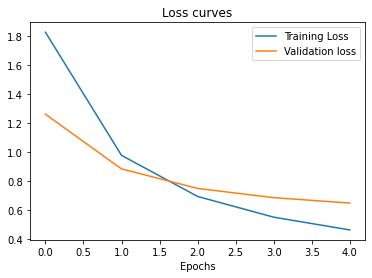

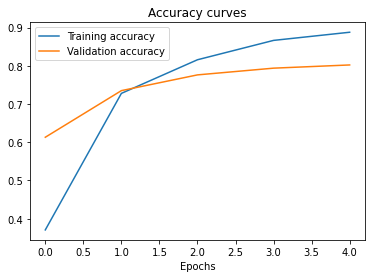

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
validation_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(history.history['loss']))

# plot the loss curve
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation loss')
plt.legend()
plt.xlabel("Epochs")
plt.title('Loss curves')

plt.figure()

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.title('Accuracy curves');

## 2. Name 3 different image classification models on TensorFlow Hub that we haven't used.

- [RegNet-Y](https://tfhub.dev/s?module-type=image-classification,image-feature-vector&network-architecture=regnety)
- [NasNet-A](https://tfhub.dev/s?module-type=image-classification,image-feature-vector&network-architecture=nasnet-a-large)
- [MobileViT](https://tfhub.dev/s?module-type=image-classification,image-feature-vector&network-architecture=mobilevit)

## 3. Build a model to classify images of two different things you've taken photos of.
    
- You can use any feature extraction layer from TensorFlow Hub you like for this.
- You should aim to have at least 10 images of each class, for example to build a truck versus car classifier, you'll want 10 images of fridges and 10 images of ovens.


For this exercise let's build human classifier. I've formatted the data from `unsplash_lite_dataset` and created a dataset which have humans and non-human.

So we want our neural network to predict from two classes.

I'll take `EfficientNet` architecture feature extractor model for this project.


In [5]:
# File path
file_path = "drive/MyDrive/Data Science/CNNExercise/human-classifier/"
train_dir = f'{file_path}train/'
test_dir = f'{file_path}test/'

In [6]:
# model url
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

IMG_SHAPE = (224, 224)
BATCH_SIZE = 32

In [10]:
# Check how many files/images we have
import os

for dirpath,dirnames,filenames in os.walk(file_path):
  print(f"There are {len(dirnames)} directories and {len(filenames)} files in '{dirpath}'")

There are 2 directories and 0 files in 'drive/MyDrive/Data Science/CNNExercise/human-classifier/'
There are 2 directories and 0 files in 'drive/MyDrive/Data Science/CNNExercise/human-classifier/train'
There are 0 directories and 160 files in 'drive/MyDrive/Data Science/CNNExercise/human-classifier/train/human'
There are 0 directories and 160 files in 'drive/MyDrive/Data Science/CNNExercise/human-classifier/train/non-human'
There are 2 directories and 0 files in 'drive/MyDrive/Data Science/CNNExercise/human-classifier/test'
There are 0 directories and 50 files in 'drive/MyDrive/Data Science/CNNExercise/human-classifier/test/human'
There are 0 directories and 50 files in 'drive/MyDrive/Data Science/CNNExercise/human-classifier/test/non-human'


So we have 160 images for Training set and 50 images for Test set

In [ ]:
# Create the End-To-End workflow

## import libraries
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime

## Instantiate ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

## Create Train and Test set
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMG_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode='binary')
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMG_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode='binary')

## Create a Tensorboard callback to visualize the performace
def create_tensorboard_callbacks_human(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.strftime('%Y%m%D-%H%')
  tensorboard_callback = tensorflow.keras.callbacks-

